# Initialize pyspark environment

In [1]:
import findspark

# initialize findspark with spark directory

#ALWAYS HAVE TO BE CHANGED 
#path = "/Users/konstantinlazarov/Desktop/Big_Data/PySpark/Week_5/spark"
path = "/Users/Artur/spark"
findspark.init(path) 

# import pyspark
import pyspark
# create spark context
sc = pyspark.SparkContext()
# create spark session 
spark = pyspark.sql.SparkSession(sc)

In [2]:
'''Voor Konstantin 
# import pyspark
import pyspark
# create spark context
sc = pyspark.SparkContext()
# create spark session 
spark = pyspark.sql.SparkSession(sc)
'''

'Voor Konstantin \n# import pyspark\nimport pyspark\n# create spark context\nsc = pyspark.SparkContext()\n# create spark session \nspark = pyspark.sql.SparkSession(sc)\n'

# Import necessary packages and data

#### Import necessary packages

In [3]:
# import packages
import os 
import pickle

import re
from datetime import datetime
import requests

import pytz
import emojis

import pandas as pd
import numpy as np

import ast

import pyspark.sql.functions as F
from pyspark.sql.types import *

from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover

import tweepy
import csv
import time
import pandas as pd
import datetime
import os
import json
from pandas.tseries.holiday import nearest_workday, \
    AbstractHolidayCalendar, Holiday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, \
    USMemorialDay, USLaborDay, USThanksgivingDay
from datetime import date

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from string import punctuation
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.tokenize import word_tokenize

from nltk.tokenize.treebank import TreebankWordDetokenizer
import re

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Import the twitter data 

In [4]:
list_brands = ["healthyfood",
               "healthylifestyle",
               "vegan",
               "keto",
               "ketodiet",
               "ketolifestyle",
               "veganism",
               "vegetarian"]
from re import search



data_dir = ".././../data/Topic/"
tweet_files = [os.path.join(data_dir, obs) for obs in os.listdir(data_dir)]



files_brand = [file for file in tweet_files if (file.find(list_brands[2]) != -1)]
files_brand               
               
df_json = spark.read.option("multiline","true").json(files_brand)  
df_json.count()



1827680

# Predict the engagement rate of a tweet

## 1. Goal of our analysis

In this notebook, we are going to predict the engagement rate of tweets. Further, it will be interesting to see the driving factors behind the engagement rate. This can be valuable information when creating an own social media brand or when you want to increase the reach of your tweets.

We start by selecting the interesting variables for this analysis.

In [5]:
# Select the interesting variables
basetable_engr = df_json.select(F.col('created_at').alias('tweet_created'), \
                                   F.col('entities.symbols').alias('symbols'), \
                                   F.col('display_text_range').alias('text_range'), \
                                   F.col('extended_entities.media.type').alias('media_type'), \
                                   F.col('favorite_count'), \
                                   F.col('full_text'), \
                                   F.col('is_quote_status').alias('quoted'), \
                                   F.col('lang').alias('language'), \
                                   F.col('retweet_count'),\
                                   F.col('user.created_at').alias('user_created'), \
                                   F.col('user.followers_count').alias('user_followers'), \
                                   F.col('user.friends_count').alias('user_following'), \
                                   F.col('user.verified').alias('user_verified'), \
                                   F.col("user.screen_name"))

Next, we perform some basic preprocessing steps on this dataset.

In [6]:
# First, we  convert Twitter date string format
def getDate(date):
    if date is not None:
        return str(datetime.datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate, StringType())

# apply udf
basetable_engr = basetable_engr.withColumn('tweet_created', F.to_utc_timestamp(date_udf("tweet_created"), "UTC"))
basetable_engr = basetable_engr.withColumn('user_created', F.to_utc_timestamp(date_udf("user_created"), "UTC"))

In [7]:
#drop duplicates and retweets 
basetable_engr = basetable_engr.filter(~F.col("full_text").startswith("RT"))\
                        .drop_duplicates()

#sorting such when dropping later we only keep the most recent post 
basetable_engr = basetable_engr.sort("tweet_created", ascending=False)

#removing spam accounts 
basetable_engr = basetable_engr.drop_duplicates(["full_text", "screen_name"])

Before we start the feature engineering, we need to filter our data. As we will use the vader package to determine the sentiment later in this notebook, we will only work with English tweets. As our insights in the data will be primarily for European and American companies and most of our tweets are in English, we do not see this as a problem.

In [8]:
# filter the data on language
basetable_engr = basetable_engr.filter(F.col("language") == "en")

In [9]:
## testing if we can compile the model for a smaller data set 
basetable_engr = basetable_engr.sample(0.01) #taking 1 procent of the data 
basetable_engr.count()

4653

# 2. Create the dependent variable

First, we start by defining our dependent variable. The engagement rate has already been discussed in the data exploration section. We will use the same definition in order to create a model to predict the engagement rate. Below, we repeat this definition:

In this analysis, engagement on Twitter is measured by the number of retweets and favorites. Your Twitter engagement rate is your engagement figure divided the number of followers of the user

In [10]:
# add engagement rate to the dataframe
basetable_engr = basetable_engr.withColumn('eng_rate', ((basetable_engr['favorite_count'] + basetable_engr['retweet_count'])/basetable_engr['user_followers']))


Check if the dependent variable has no null values, this could be the case if the user has no followers. In this case, we will set the value of the engagement rate to zero.

In [12]:
# check missing values for the dependent variable
df = basetable_engr.select(F.col('eng_rate'))
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).toPandas()



,eng_rate
0,60


In [13]:
# handle the null values in the dependent variable for the created dataframe
df = df.fillna(0)

# inspect
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).toPandas()

,eng_rate
0,0


In [11]:
# handle the dependent variable in the basetable
basetable_engr = basetable_engr.fillna({'eng_rate': 0})

# 3. Feature engineering

In order to predict the engagement of a tweet, we will create some additional features in order to improve the performance of our model. For most of these features, we will first creata a function. The following features will be created:

    1) number of words
    2) number of hashtags
    3) number of tags
    4) number of emojis
    5) get the number of exclamation marks
    6) the month
    7) day of the month
    8) day of the week
    9) hour of the day
    10) The number of upper case words
    11) tweeted quote
    12) presence of a symbol
    13) The age of the account
    14) The number of media elements
    15) The media type present
    16) The number of text characters in the tweet
    17) Indicator if the account is verified

These features will be used next to some variables that are already present in the dataset.

    1) For the number of words, we can just use the function F.size() and apply it to the tokenized text. 

In [12]:
# 2) Define function to count hashtags
def get_hashtags(text):
    counter = 0
    for letter in text:
        if letter == "#":
            counter += 1
    return(counter)

In [13]:
# 3) Define function to count tags
def get_tags(text):
    counter = 0
    for letter in text:
        if letter == "@":
            counter += 1
    return(counter)

In [14]:
# 4) Define a function to get the number of emojis
def emoji_counter(text):
    nr_emojis = emojis.count(text)
    return(nr_emojis)

In [15]:
# 5) Define function to count exclamation marks
def get_exclamation_marks(text):
    counter = 0
    for letter in text:
        if letter ==  "!":
            counter += 1
    return(counter)

    6) the month
    7) day of the month
    8) day of the week
    9) hour of the day

We saw how to create these variables when solving the questions for this assignment. The same code will be used here. 

In [16]:
# 10) Define number of upper case words
def get_upper_case_words(text):
    counter = 0
    
    ## Tokenize
    word_tokens = word_tokenize(text)

    ## Check for uppercase words
    for word in word_tokens:
        if word.isupper():
            counter += 1
    return(counter)

In [17]:
# 11) Define a function that indicates if the tweet was a quote
def tweeted_quote_indicator(quoted):
    quote = 0
    if quoted == True:
        quote = 1
    return quote

In [18]:
# 12) define a function that indicates the presence of a symbol
def symbol_indicator(symbols):
    symbol = 0
    if(symbols > 0):
        symbol = 1
    return symbol

    13) Define the age of the account. This is defined as the number of days since the account has been created and the last day of scraping (2022-10-11). The last day of scraping was calculated in the exploration phase of the data. For this variable, we will use the function datediff.

In [19]:
# 14) define a function to get help get the number of media types included in the tweet
def adjust_nr_media(number):
    if number == -1:
        number = 0
        
    return number

In [20]:
# 15) define a function to get the first media element
def get_media_type(media):
    if media == None:
        media = 'no_media'
    else:
        media = media[0]
       
    return media

In [21]:
# 16) define a function to get the first media element
def get_nr_text_characters(text_range):
    number = text_range[1] - text_range[0]  
    return number



In [22]:
# 17) Look if the user is a verified user
def verified_ind(verified):
    indicator = 0
    if verified == True:
        indicator = 1
    return indicator

In [23]:
# register the functions as an udf
get_upper_case_words_UDF = F.udf(get_upper_case_words, IntegerType()) 
emoji_counter_udf = F.udf(emoji_counter, IntegerType())
get_hashtags_udf = F.udf(get_hashtags, IntegerType())
get_tags_udf = F.udf(get_tags, IntegerType())
get_exclamation_marks_UDF = F.udf(get_exclamation_marks, IntegerType())
tweeted_quote_indicator_UDF = F.udf(tweeted_quote_indicator, IntegerType())
symbol_indicator_udf = F.udf(symbol_indicator, IntegerType())
adjust_nr_media_udf = F.udf(adjust_nr_media, IntegerType())
get_media_type_udf = F.udf(get_media_type, StringType())
get_nr_text_characters_udf = F.udf(get_nr_text_characters, IntegerType())
verified_ind_udf = F.udf(verified_ind, IntegerType())

In [24]:
# Already define some text cleaning steps in order to define the correct number of words.

# define puncutation and stopwords
PUNCTUATION = [char for char in punctuation if char not in ["!", "@", "#"]]
STOPWORDS = stopwords.words("english")

# define function to remove punctuation
def remove_punct(text):
    ## Remove punctuation
    text = "".join([char for char in text if char not in PUNCTUATION])
    return(text)

# define function to remove stopwords
def remove_stops(text_tokenized):
    # remove stopwords
    text_tokenized = [word for word in text_tokenized if word not in STOPWORDS]
    return(text_tokenized)

# register as udf
remove_punct_UDF = F.udf(remove_punct, StringType())
remove_stops_UDF = F.udf(remove_stops, ArrayType(StringType()))

In [25]:
# create the final basetable for our analysis
basetable_engr_final = basetable_engr.withColumn("num_emojis", emoji_counter_udf(F.col("full_text")))\
                            .withColumn('upper_case_words', get_upper_case_words_UDF('full_text'))\
                            .withColumn("text_lower", F.lower("full_text")) \
                            .withColumn("text_cleaned", remove_punct_UDF("text_lower")) \
                            .withColumn("text_tokenized", F.split("text_cleaned", " ")) \
                            .withColumn("text_tokenized_no_stops", remove_stops_UDF("text_tokenized")) \
                            .withColumn("num_words", F.size("text_tokenized_no_stops")) \
                            .withColumn("num_hashtags", get_hashtags_udf("text_tokenized_no_stops")) \
                            .withColumn("num_mentions", get_tags_udf("text_tokenized_no_stops")) \
                            .withColumn('nr_exlcamations', get_exclamation_marks_UDF('text_tokenized_no_stops'))\
                            .withColumn("week_day", F.date_format(F.col("tweet_created"), "E"))\
                            .withColumn("hour", F.date_format(F.col("tweet_created"), "H").cast('string'))\
                            .withColumn("month", F.date_format(F.col("tweet_created"), "M"))\
                            .withColumn("day_month", F.date_format(F.col("tweet_created"), "d"))\
                            .withColumn('quoted_ind', tweeted_quote_indicator_UDF('quoted'))\
                            .withColumn('symbol_ind', F.size('symbols'))\
                            .withColumn('symbol_ind', symbol_indicator_udf('symbol_ind'))\
                            .withColumn('user_age_days', F.datediff(F.lit("2022-10-11"), F.col("user_created")))\
                            .withColumn('verified', verified_ind_udf('user_verified'))\
                            .withColumn("nr_media_elements", F.size("media_type"))\
                            .withColumn("nr_media_elements", adjust_nr_media_udf("nr_media_elements"))\
                            .withColumn("media_type", get_media_type_udf('media_type'))\
                            .withColumn("nr_text_char", get_nr_text_characters_udf('text_range'))\
                            .drop('tweet_created')\
                            .drop('quoted')\
                            .drop('symbols')\
                            .drop('user_created')\
                            .drop('user_verified')\
                            .drop('display_text_range')\
                            .drop('text_lower')\
                            .drop('text_cleaned')\
                            .drop('text_tokenized')\
                            .drop('text_tokenized_no_stops')\
                            .drop('text_range')\
                            .filter("num_words > 0")



In [27]:
# inspect the data
#basetable_engr_final.toPandas().head()

,media_type,favorite_count,full_text,language,retweet_count,user_followers,user_following,screen_name,eng_rate,num_emojis,...,week_day,hour,month,day_month,quoted_ind,symbol_ind,user_age_days,verified,nr_media_elements,nr_text_char
0,photo,0,"""In every walk with nature, one receives far m...",en,1,1988,4170,cbd1uk,0.000503,0,...,Fri,16,8,5,0,0,1918,0,1,267
1,no_media,1,"""Next time you feel compelled to critique a st...",en,0,691,2864,ckrummey,0.001447,0,...,Tue,15,6,28,0,0,4249,0,0,280
2,no_media,2,"""Sentientism goes further than humanism.. beca...",en,0,2657,2556,TenacityMatters,0.000753,0,...,Sat,17,10,30,0,0,699,0,0,280
3,no_media,3,"""is this vegan??"" \n\n""oh i'm sorry, i should ...",en,0,128,111,Tweedledummi,0.023438,0,...,Sat,16,7,2,0,0,1241,0,0,98
4,photo,1,#FakeSteak ready for roasting to ram in #BaoBu...,en,0,2701,5002,LWHawksby,0.000370,0,...,Tue,17,2,1,0,0,2093,0,1,142


# 3. Text Cleaning 

In [26]:
import emoji

Now, we are going to clean the text of the twitter data. Then, we can use this cleaned text to extract features about the sensitivity of the tweet.

Here, we remove numbers, punctuation, urls... Further, we transform the emojis to words. Emojis are at the very core of communication over social channels. One small image can completely describe one or more human emotions. A naive thing to do during pre-processing would be to remove all emojis. This could result in significant loss of meaning.
A good way to achieve this is to replace the emoji with corresponding text explaining the emoji.

In [27]:
# define function to clean text
def clean_text(string):
    
    # define numbers
    NUMBERS = '0123456789'
    PUNCT = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    
    # convert text to lower case
    cleaned_string = string.lower()
    
    # remove URLS
    cleaned_string = re.sub(r'http\S+', ' ', cleaned_string)
    
    # replace emojis by words
    cleaned_string = emoji.demojize(cleaned_string)
    cleaned_string = cleaned_string.replace(":"," ").replace("_"," ")
    cleaned_string = ' '.join(cleaned_string.split())
    
    # remove numbers
    cleaned_string = "".join([char for char in cleaned_string if char not in NUMBERS])
    
    # remove punctuation
    cleaned_string = "".join([char for char in cleaned_string if char not in PUNCT])
    
    # remove words conisting of one character (or less)
    cleaned_string = ' '.join([w for w in cleaned_string.split() if len(w) > 1])
    
    # return
    return(cleaned_string)

In [28]:
# convert to udf
clean_text_udf = F.udf(clean_text, StringType())

In [29]:
# clean string
basetable_engr_final = basetable_engr_final.withColumn("cleaned_text", clean_text_udf(F.col("full_text")))

In [35]:
# check the data
#basetable_engr_final.select("full_text", "cleaned_text").limit(5).toPandas()

,full_text,cleaned_text
0,"""I'm not a vegan. Or vegetarian. Or pescataria...",im not vegan or vegetarian or pescatarian or a...
1,"""If slaugher was really ""humane"" it would be t...",if slaugher was really humane it would be the ...
2,#BTS Holiday shoot. Coming soon! 👩🏼‍🍳🥘🍨🦃🤶🏻📹\n\...,bts holiday shoot coming soon woman cook mediu...
3,#DidYouKnow that today is #NationalCherryDay? ...,didyouknow that today is nationalcherryday we ...
4,#HADV #CBD #infused #Wine #Beverage #Cannabis ...,hadv cbd infused wine beverage cannabis health...


Now that the text is cleaned, we can derive the sentiment of the text. In this next section, we derive the sentiment, the subjectivity and the polarity. These are the tree final features we add to our model.

In [30]:
# define the function to extract the sentiment
def get_sentiment(sentence):

    # initialize sentiment analyzer
    sid_obj = SentimentIntensityAnalyzer()

    # get sentiment dict
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    # get positive sentiment score
    pos_sentiment = sentiment_dict["pos"]
    
    # return positive sentiment score
    return(pos_sentiment)

# define function to get polarity score of text 
def get_polarity(row):
    textBlob_review = TextBlob(row)
    return textBlob_review.sentiment[0]

# define function to get subjectivity score of text 
def get_subjectivity(row):
    textBlob_review = TextBlob(row)
    return textBlob_review.sentiment[1]


# register the functions as udf
get_sentiment_udf = F.udf(get_sentiment, DoubleType())
get_polarity_udf = F.udf(get_polarity, DoubleType())
get_subjectivity_udf = F.udf(get_subjectivity, DoubleType())

In [31]:
# Create the final basetable for our analysis
basetable_engr_final = basetable_engr_final.withColumn("sentiment", get_sentiment_udf(F.col("cleaned_text")))\
                                .withColumn('polarity', get_polarity_udf(F.col('cleaned_text')))\
                                .withColumn('subjectivity', get_subjectivity_udf(F.col('cleaned_text')))

# 4. Basetable creation

In [32]:
# Inspect the structure of the basetable:
basetable_engr_final.printSchema()

root
 |-- media_type: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- full_text: string (nullable = true)
 |-- language: string (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- user_followers: long (nullable = true)
 |-- user_following: long (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- eng_rate: double (nullable = false)
 |-- num_emojis: integer (nullable = true)
 |-- upper_case_words: integer (nullable = true)
 |-- num_words: integer (nullable = false)
 |-- num_hashtags: integer (nullable = true)
 |-- num_mentions: integer (nullable = true)
 |-- nr_exlcamations: integer (nullable = true)
 |-- week_day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_month: string (nullable = true)
 |-- quoted_ind: integer (nullable = true)
 |-- symbol_ind: integer (nullable = true)
 |-- user_age_days: integer (nullable = true)
 |-- verified: integer (nullable = true)
 |-- nr_media

    - Check for missing values. If there are some - handle them (delete, impute,..). In this exercise: write code to handle them even if they aren't present.
    - Adjust datatypes where needed
    - Remove unnecessary columns
    - Add data pre-processing steps to the pipeline

## 4.1 Drop unnecessary columns

In [33]:
# drop (the 3 last variables were used to define the dependent variable)
basetable_engr_final = basetable_engr_final.drop('full_text')\
                                .drop('screen_name')\
                                .drop('language')\
                                .drop('cleaned_text')\
                                .drop('retweet_count')\
                                .drop('tokens_stemmed')\
                                .drop('favorite_count')\
                                .drop('user_followers')


In [34]:
# inspect the data
basetable_engr_final.printSchema()

root
 |-- media_type: string (nullable = true)
 |-- user_following: long (nullable = true)
 |-- eng_rate: double (nullable = false)
 |-- num_emojis: integer (nullable = true)
 |-- upper_case_words: integer (nullable = true)
 |-- num_words: integer (nullable = false)
 |-- num_hashtags: integer (nullable = true)
 |-- num_mentions: integer (nullable = true)
 |-- nr_exlcamations: integer (nullable = true)
 |-- week_day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_month: string (nullable = true)
 |-- quoted_ind: integer (nullable = true)
 |-- symbol_ind: integer (nullable = true)
 |-- user_age_days: integer (nullable = true)
 |-- verified: integer (nullable = true)
 |-- nr_media_elements: integer (nullable = true)
 |-- nr_text_char: integer (nullable = true)
 |-- sentiment: double (nullable = true)
 |-- polarity: double (nullable = true)
 |-- subjectivity: double (nullable = true)



In [41]:
# inspect the data
#basetable_engr_final.toPandas().head(5)

,media_type,user_following,eng_rate,num_emojis,upper_case_words,num_words,num_hashtags,num_mentions,nr_exlcamations,week_day,...,day_month,quoted_ind,symbol_ind,user_age_days,verified,nr_media_elements,nr_text_char,sentiment,polarity,subjectivity
0,no_media,122,0.000000,0,2,8,0,0,0,Sat,...,30,0,0,2546,0,0,89,0.137,0.500000,0.50
1,no_media,25712,0.000080,0,0,13,0,0,0,Thu,...,28,0,0,2714,0,0,132,0.118,0.200000,0.20
2,video,276,0.027027,7,1,11,0,0,0,Fri,...,5,0,0,554,0,1,99,0.087,0.033333,0.60
3,photo,1013,0.000000,0,0,25,0,0,0,Sat,...,16,0,0,3690,0,1,273,0.104,0.500000,0.55
4,no_media,89158,0.000060,0,4,31,0,0,0,Thu,...,8,1,1,3401,0,0,261,0.224,0.500000,0.50


## 4.2 Handle missing values

We see that there are no missing values in our dataset, so this step is completed.

In [42]:
# check missing values (also null values were checked but are not shown)
basetable_engr_final.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in basetable_engr_final.columns]).toPandas().head()                                         

,media_type,user_following,eng_rate,num_emojis,upper_case_words,num_words,num_hashtags,num_mentions,nr_exlcamations,week_day,...,day_month,quoted_ind,symbol_ind,user_age_days,verified,nr_media_elements,nr_text_char,sentiment,polarity,subjectivity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Further, we see that our variables all have the correct datatype.

# 5. Modelling

In this part, we are going to train a random forest classification model on the training data. This is an advanced machine learning model of which we expect good performance. After we train this model, we will evaluate it. As the goal of our analysis was to find the driving factors behind the engagement rate, we will use the shap values to determine variable importance. This way, we know in which direction the variable affects the engagement rate.

We start by handling our dependent variable, which we make categorical. Then, we use the StringIndexer to create the right input for the model.

In [35]:
# First, we need to categorize our dependent variable in order to make it categorical
from pyspark.ml.feature import Bucketizer
basetable_engr_final = Bucketizer(
    splits=[-float('inf'), 0.015, 0.05, float('inf')],
    inputCol='eng_rate',
    outputCol='label_cat'
).transform(basetable_engr_final)

In [36]:
# inspect
basetable_engr_final.groupBy('label_cat').count().show()

+---------+-----+
|label_cat|count|
+---------+-----+
|      0.0| 3995|
|      1.0|  340|
|      2.0|  318|
+---------+-----+



## 5.1 Split the data in train and test set

In [37]:
# split data in train and test set
train, test = basetable_engr_final.randomSplit([0.7, 0.3], seed= 100)

In [137]:
# check number of observations in both datasets
#print("Number of observations in the training set: %s " % train.count())
#print("Number of observations in the test set: %s " %test.count())

In [47]:
# inspect the training data
#train.toPandas().head()

,media_type,user_following,eng_rate,num_emojis,upper_case_words,num_words,num_hashtags,num_mentions,nr_exlcamations,week_day,...,quoted_ind,symbol_ind,user_age_days,verified,nr_media_elements,nr_text_char,sentiment,polarity,subjectivity,label_cat
0,animated_gif,96,0.000000,1,2,22,0,0,0,Wed,...,0,0,2652,0,1,181,0.000,0.000000,0.066667,0.0
1,animated_gif,266,0.000000,1,0,6,0,0,0,Thu,...,0,0,2224,0,1,41,0.000,-0.145833,0.520833,0.0
2,animated_gif,433,0.011364,1,0,6,0,0,0,Thu,...,0,0,337,0,1,35,0.412,0.000000,0.000000,0.0
3,no_media,0,0.000000,0,0,26,0,0,0,Sat,...,0,0,840,0,0,258,0.102,0.000000,0.750000,0.0
4,no_media,0,0.000000,0,0,26,0,0,0,Sun,...,0,0,72,0,0,276,0.547,0.460417,0.562500,0.0


#### handle class imbalance in dependent variable

In [38]:
# first define the number of training observations
nr_train_obs = train.count()
print(nr_train_obs)

3175


In [39]:
# define the number of observations per label
train_obs_0 = train.filter(F.col('label_cat') == 0.0).count()
train_obs_1 = train.filter(F.col('label_cat') == 1.0).count()
train_obs_2 = train.filter(F.col('label_cat') == 2.0).count()

In [55]:
# Now define weights of labels (based on 1% of the data due to computation time)
weight_0 = (nr_train_obs)/(3*train_obs_0)
weight_1 = (nr_train_obs)/(3*train_obs_1)
weight_2 = (nr_train_obs)/(3*train_obs_2)
print(weight_0)
print(weight_1)
print(weight_2)

0.3876678876678877
4.50354609929078
4.581529581529582


In [41]:
# insert weight column into training and test set
train = train.withColumn("weight", F.when(F.col("label_cat") == 1, weight_1)\
                         .otherwise(F.when(F.col("label_cat") == 2, weight_2).otherwise(weight_0)))
test = test.withColumn("weight", F.when(F.col("label_cat") == 1, weight_1)\
                         .otherwise(F.when(F.col("label_cat") == 2, weight_2).otherwise(weight_0)))


In [42]:
# inspect the weights
train.select(F.col('weight')).show(5)

+------------------+
|            weight|
+------------------+
|0.3876678876678877|
|0.3876678876678877|
|0.3876678876678877|
|  4.50354609929078|
|0.3876678876678877|
+------------------+
only showing top 5 rows



## 5.2 Pipelines

**Import required transformers and estimators**

In [43]:
# import pyspark ml packages
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover, StandardScaler, Word2Vec
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

# import models and evaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### Define the different pipeline stages 

In [44]:
# Create string indexer for the dependent variable
IDX = StringIndexer(inputCol = 'label_cat', outputCol = 'label')

#### handle numeric features

In [45]:
# define the numeric variables
num_cols = ['user_following', 'num_emojis', 'upper_case_words','num_words',
            'num_hashtags', 'num_mentions', 'nr_exlcamations',  'user_age_days', 
            'nr_media_elements', 'nr_text_char']

# define the assembler
num_VA = VectorAssembler(inputCols=num_cols, outputCol="num_features")

In [46]:
# define the scaler
SS = StandardScaler(inputCol="num_features", outputCol="num_features_scaled")

#### handle categorical features

First, we transform the text variables in our dataset into numerical categories

In [47]:
# define the categorical variables
cat_cols = ['media_type', 'hour', 'week_day', 'month', 'day_month', 'quoted_ind',
           'symbol_ind', 'verified']

# create an object of StringIndexer class for each categorical variable
SI_media = StringIndexer(inputCol= 'media_type', outputCol= 'media_type_index')
SI_hour = StringIndexer(inputCol= 'hour', outputCol= 'hour_index')
SI_week_day = StringIndexer(inputCol= 'week_day', outputCol= 'week_day_index')
SI_month = StringIndexer(inputCol= 'month', outputCol= 'month_index')
SI_day_month = StringIndexer(inputCol= 'day_month', outputCol= 'day_month_index')

Next, we One Hot Encode categorical variables in numeric format

In [48]:
# define the categorical variables that are already in NUMERIC format
cat_cols_num = ['media_type_index', 'hour_index', 'week_day_index', 'month_index', 
                    'day_month_index','quoted_ind', 'symbol_ind', 'verified']

# define new names of encoded categorical variables
catColumnsOHE = [name  + "_OHE" for name in cat_cols_num]

# define one hot encoder
encoder = OneHotEncoder(inputCols = cat_cols_num, outputCols = catColumnsOHE)

In [49]:
# define the categorical variables that are already in NUMERIC format
cat_VA_LR = VectorAssembler(inputCols= catColumnsOHE, outputCol="cat_features")


For the random forest model, replace the OneHotEncoder with a VectorIndexer

In [50]:
# define VA for the random forest model
cat_VA_RF = VectorAssembler(inputCols= cat_cols_num, outputCol="cat_features_idx")

# Define VectorIndexer
indexer = VectorIndexer(inputCol = 'cat_features_idx', outputCol = 'cat_features')

Next, we use a VectorAssembler to assemble all encoded variables together.

In [51]:
# define vector assembler
VA_all_LR = VectorAssembler(inputCols=["num_features_scaled", "cat_features", "polarity", "subjectivity", "sentiment"], outputCol="features")

In [52]:
# for random forest we don't scale the features 
VA_all_RF = VectorAssembler(inputCols=["num_features", "cat_features", "polarity", "subjectivity", "sentiment"], outputCol="featuresrf")

In [53]:
# define logistic regression model
LR = LogisticRegression(featuresCol = "features", labelCol = "label", weightCol= "weight",
                       regParam =  0.8, maxIter =  10)

# define logistic regression model withour weights
LR_without = LogisticRegression(featuresCol = "features", labelCol = "label", 
                               regParam =  0.0, maxIter =  100)

In [54]:
# define random forest model
RF = RandomForestClassifier(featuresCol = "featuresrf", labelCol = "label", weightCol= "weight",
                           maxDepth = 15, maxBins = 32, numTrees = 20)

# define logistic regression model withour weights
RF_without = RandomForestClassifier(featuresCol = "featuresrf", labelCol = "label",
                                   maxDepth = 5, maxBins = 32, numTrees = 20)


## 5.3 Train a logistic regression

To train the logistic regression model, we first performed cross validation while training the model on 1% of the training set. Not a lot of parameters could be tested at once due to memory issues. However, with the parameters found of the best cross validation model, we retrained the model on 10% of the data. The parameters were already set in the pipeline stage of this model. Below, you find the code of the cross validation in the comments.

In [54]:
# first define the pipeline for the logistic regression without fitting the data
#LR_pipeline = Pipeline().setStages([IDX, num_VA, SS,SI_media, SI_hour, SI_week_day, SI_month,
#                                   SI_day_month, encoder, cat_VA_LR, VA_all_LR, LR])

In [55]:
# define the parameter space 
#paramGrid = (ParamGridBuilder()
#             .addGrid(LR.regParam, [0.1, 0.8])
#             .addGrid(LR.maxIter, [3, 10])
#             .build())

In [60]:
# define evaluator 
#evaluator_mc = MulticlassClassificationEvaluator()

In [57]:
# define cross validator
#cv = CrossValidator(estimator = LR_pipeline,
#                    estimatorParamMaps = paramGrid,
#                    evaluator = evaluator_mc, 
#                    numFolds = 5)

In [58]:
# perform 5-fold cross validation for defined parameter space (train on train set with fit)
#LR_cv_model = cv.fit(train)

In [70]:
# print the parameters of the best model
#print("regParam = ", LR_cv_model.bestModel.stages[-1]._java_obj.getRegParam())
#print("elasticNetParam = ", LR_cv_model.bestModel.stages[-1]._java_obj.getElasticNetParam())
#print("maxIter = ", LR_cv_model.bestModel.stages[-1]._java_obj.getMaxIter())

regParam =  0.8
elasticNetParam =  0.0
maxIter =  10


In [65]:
# get predictions on test set (test on test set with transform)
#predictions = LR_cv_model.transform(test)

#### Do the same for the model without weights.

In [56]:
# first define the pipeline for the logistic regression without fitting the data
#LR_pipeline_without = Pipeline().setStages([IDX, num_VA, SS,SI_media, SI_hour, SI_week_day, SI_month,
#                                  SI_day_month, encoder, cat_VA_LR, VA_all_LR, LR_without])

In [58]:
# define the parameter space 
#paramGrid = (ParamGridBuilder()
#             .addGrid(LR.regParam, [0.1, 0.8])
#             .addGrid(LR.maxIter, [3, 10])
#             .build())

In [61]:
# define cross validator
#cv_w = CrossValidator(estimator = LR_pipeline_without,
#                   estimatorParamMaps = paramGrid,
#                   evaluator = evaluator_mc, 
#                   numFolds = 5)

In [62]:
# perform 5-fold cross validation for defined parameter space (train on train set with fit)
#LR_cv_model_without = cv_w.fit(train)

In [63]:
# print the parameters of the best model
#print("regParam = ", LR_cv_model_without.bestModel.stages[-1]._java_obj.getRegParam())
#print("elasticNetParam = ", LR_cv_model_without.bestModel.stages[-1]._java_obj.getElasticNetParam())
#print("maxIter = ", LR_cv_model_without.bestModel.stages[-1]._java_obj.getMaxIter())

regParam =  0.0
elasticNetParam =  0.0
maxIter =  100


#### Train the logistic regression model with optimal parameters on 10% of the data.

In [76]:
# define pipeline model and fit on training data
LR_pipeline = Pipeline().setStages([IDX, num_VA, SS,SI_media, SI_hour, SI_week_day, SI_month,
                                    SI_day_month, encoder, cat_VA_LR, VA_all_LR, LR])\
                        .fit(train)

LR_pipeline_w = Pipeline().setStages([IDX, num_VA, SS,SI_media, SI_hour, SI_week_day, SI_month,
                                    SI_day_month, encoder, cat_VA_LR, VA_all_LR, LR_without])\
                        .fit(train)

# get predictions on test set
LR_preds = LR_pipeline.transform(test)
LR_preds_w = LR_pipeline_w.transform(test)

#### Evaluate

In [77]:
# define evaluator (for other metrics)
evaluator_mc = MulticlassClassificationEvaluator()

In [78]:
# get metrics for LR model
lr_f1 = evaluator_mc.evaluate(LR_preds, {evaluator_mc.metricName: "f1"})
lr_accuracy = evaluator_mc.evaluate(LR_preds, {evaluator_mc.metricName: "accuracy"})
lr_recall = evaluator_mc.evaluate(LR_preds, {evaluator_mc.metricName: "weightedRecall"})
lr_precision = evaluator_mc.evaluate(LR_preds, {evaluator_mc.metricName: "weightedPrecision"})
lr_weighted_TPR = evaluator_mc.evaluate(LR_preds, {evaluator_mc.metricName: "weightedTruePositiveRate"})
lr_weighted_FPR = evaluator_mc.evaluate(LR_preds, {evaluator_mc.metricName: "weightedFalsePositiveRate"})

In [79]:
# get metrics for LR model
lr_f1_w = evaluator_mc.evaluate(LR_preds_w, {evaluator_mc.metricName: "f1"})
lr_accuracy_w = evaluator_mc.evaluate(LR_preds_w, {evaluator_mc.metricName: "accuracy"})
lr_recall_w = evaluator_mc.evaluate(LR_preds_w, {evaluator_mc.metricName: "weightedRecall"})
lr_precision_w = evaluator_mc.evaluate(LR_preds_w, {evaluator_mc.metricName: "weightedPrecision"})
lr_weighted_TPR_w = evaluator_mc.evaluate(LR_preds_w, {evaluator_mc.metricName: "weightedTruePositiveRate"})
lr_weighted_FPR_w = evaluator_mc.evaluate(LR_preds_w, {evaluator_mc.metricName: "weightedFalsePositiveRate"})

Let's refresh the definition of the different metrics:

    1)The F-measure is calculated as the harmonic mean of precision and recall, giving each the same weighting. It allows a model to be evaluated taking both the precision and recall into account using a single score, which is helpful when describing the performance of the model and in comparing models.
    2) Accuracy = Number of correct predictions of the total number of predictions
    3) Recall = the number of correct positive predictions made out of all positive predictions that could have been made
    4)  Precision = to the number of true positives divided by the total number of positive predictions 
    5) Weighted true positive rate = gives the weighted mean of class TPR with weights equal to class probability. TPR is the probability that an actual positive will test positive.
    6) The Weighted False Positive Rate gives the weighted mean of class False Positive Rate (FPR) with weights equal to class probability. The FPR is the proportion of negative cases incorrectly identified as positive cases in the data.
    
For more inforamtion: https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html

In [81]:
# check which of both algorithms is the best:
print("LOGISTIC REGRESSION:")
print('  F1       : %g' % lr_f1)
print('  ACCURACY : %g' % lr_accuracy)
print('  RECALL   : %g' % lr_recall)
print('  PRECISION   : %g' % lr_precision)
print('  WEIGHTED_TPR   : %g' % lr_weighted_TPR)
print('  WEIGHTED_FPR   : %g' % lr_weighted_FPR)

print("LOGISTIC REGRESSION without weights:")
print('  F1       : %g' % lr_f1_w)
print('  ACCURACY : %g' % lr_accuracy_w)
print('  RECALL   : %g' % lr_recall_w)
print('  PRECISION   : %g' % lr_precision_w)
print('  WEIGHTED_TPR   : %g' % lr_weighted_TPR_w)
print('  WEIGHTED_FPR   : %g' % lr_weighted_FPR_w)

LOGISTIC REGRESSION:
  F1       : 0.656388
  ACCURACY : 0.578062
  RECALL   : 0.594886
  PRECISION   : 0.794712
  WEIGHTED_TPR   : 0.569407
  WEIGHTED_FPR   : 0.286563
LOGISTIC REGRESSION without weights:
  F1       : 0.78381
  ACCURACY : 0.854643
  RECALL   : 0.854643
  PRECISION   : 0.745604
  WEIGHTED_TPR   : 0.852525
  WEIGHTED_FPR   : 0.857916


## 5.4 Train random forest

Again, we first perform cross validation with 1% of the data. Then, we use the optimal parameters to train the model on all 10% of the data.

In [64]:
# first define the pipeline for the random forest without fitting the data
#RF_pipeline = Pipeline().setStages([IDX, num_VA,SI_media, SI_hour, SI_week_day, SI_month,
#                                    SI_day_month, cat_VA_RF, indexer, VA_all_RF, RF])

In [68]:
# define the parameter space
#rfparamGrid = (ParamGridBuilder().addGrid(RF.maxDepth, [5, 15, 30])
#                                   .build())

In [69]:
# perform 5-fold cross validation
#rfcv_model = CrossValidator(estimator=RF_pipeline, 
#                          estimatorParamMaps=rfparamGrid, 
#                          evaluator=evaluator_mc,
#                          numFolds=5)

In [70]:
# run cross validation on trainig set
#rfcv_model = rfcv_model.fit(train)

In [72]:
# inspect best params
#print("best max depth: %s" %rfcv_model.bestModel.stages[-1]._java_obj.getMaxDepth())
#print("best max bins: %s" %rfcv_model.bestModel.stages[-1]._java_obj.getMaxBins())
#print("best num trees: %s" %rfcv_model.bestModel.stages[-1]._java_obj.getNumTrees())

best max depth: 15
best max bins: 32
best num trees: 20


In [73]:
# get predictions of best model of on test set (cv_model automatically uses best model)
rfcv_preds = rfcv_model.transform(test)

#### Do the same for the model without weights

In [74]:
# first define the pipeline for the random forest without fitting the data
#RF_pipeline_w = Pipeline().setStages([IDX, num_VA,SI_media, SI_hour, SI_week_day, SI_month,
#                                    SI_day_month, cat_VA_RF, indexer, VA_all_RF, RF_without])

In [75]:
# define the parameter space
#rfparamGrid = (ParamGridBuilder().addGrid(RF.maxDepth, [5, 15, 30])
#                                   .build())

In [76]:
# perform 5-fold cross validation
#rfcv_model_w = CrossValidator(estimator=RF_pipeline_w, 
#                          estimatorParamMaps=rfparamGrid, 
#                          evaluator=evaluator_mc,
#                          numFolds=5)

In [77]:
# run cross validation on trainig set
#rfcv_model_w = rfcv_model_w.fit(train)

In [78]:
# inspect best params
#print("best max depth: %s" %rfcv_model_w.bestModel.stages[-1]._java_obj.getMaxDepth())
#print("best max bins: %s" %rfcv_model_w.bestModel.stages[-1]._java_obj.getMaxBins())
#print("best num trees: %s" %rfcv_model_w.bestModel.stages[-1]._java_obj.getNumTrees())

best max depth: 5
best max bins: 32
best num trees: 20


#### Train the random forest model with optimal parameters on 10% of the data.

In [62]:
# define pipeline model and fit on training data
RF_pipeline = Pipeline().setStages([IDX, num_VA,SI_media, SI_hour, SI_week_day, SI_month,
                                    SI_day_month, cat_VA_RF, indexer, VA_all_RF, RF])\
                        .fit(train)

RF_pipeline_w = Pipeline().setStages([IDX, num_VA,SI_media, SI_hour, SI_week_day, SI_month,
                                    SI_day_month, cat_VA_RF, indexer, VA_all_RF, RF_without])\
                        .fit(train)

In [63]:
# get predictions on test set
rf_preds = RF_pipeline.transform(test)
rf_preds_w = RF_pipeline_w.transform(test)

#### Evaluate

In [64]:
# get metrics for RF model
rf_f1 = evaluator_mc.evaluate(rf_preds, {evaluator_mc.metricName: "f1"})
rf_accuracy = evaluator_mc.evaluate(rf_preds, {evaluator_mc.metricName: "accuracy"})
rf_recall = evaluator_mc.evaluate(rf_preds, {evaluator_mc.metricName: "weightedRecall"})
rf_precision = evaluator_mc.evaluate(rf_preds, {evaluator_mc.metricName: "weightedPrecision"})
rf_weighted_TPR = evaluator_mc.evaluate(rf_preds, {evaluator_mc.metricName: "weightedTruePositiveRate"})
rf_weighted_FPR = evaluator_mc.evaluate(rf_preds, {evaluator_mc.metricName: "weightedFalsePositiveRate"})

In [ ]:
# get metrics for RF model without weights
rf_f1_w = evaluator_mc.evaluate(rf_preds_w, {evaluator_mc.metricName: "f1"})
rf_accuracy_w = evaluator_mc.evaluate(rf_preds_w, {evaluator_mc.metricName: "accuracy"})
rf_recall_w = evaluator_mc.evaluate(rf_preds_w, {evaluator_mc.metricName: "weightedRecall"})
rf_precision_w = evaluator_mc.evaluate(rf_preds_w, {evaluator_mc.metricName: "weightedPrecision"})
rf_weighted_TPR_w = evaluator_mc.evaluate(rf_preds_w, {evaluator_mc.metricName: "weightedTruePositiveRate"})
rf_weighted_FPR_w = evaluator_mc.evaluate(rf_preds_w, {evaluator_mc.metricName: "weightedFalsePositiveRate"})

In [65]:
# check which of both algorithms is the best:
print("Random Forest:")
print('  F1       : %g' % rf_f1)
print('  ACCURACY : %g' % rf_accuracy)
print('  RECALL   : %g' % rf_recall)
print('  PRECISION   : %g' % rf_precision)
print('  WEIGHTED_TPR   : %g' % rf_weighted_TPR)
print('  WEIGHTED_FPR   : %g' % rf_weighted_FPR)

# check which of both algorithms is the best:
print("Random Forest without weights:")
print('  F1       : %g' % rf_f1)
print('  ACCURACY : %g' % rf_accuracy)
print('  RECALL   : %g' % rf_recall)
print('  PRECISION   : %g' % rf_precision)
print('  WEIGHTED_TPR   : %g' % rf_weighted_TPR)
print('  WEIGHTED_FPR   : %g' % rf_weighted_FPR)

Random Forest:
  F1       : 0.803417
  ACCURACY : 0.807641
  RECALL   : 0.795165
  PRECISION   : 0.786446
  WEIGHTED_TPR   : 0.8063
  WEIGHTED_FPR   : 0.567836


# 6. Interpretation models

## 6.1 Interpretation logistic regression

In [149]:
# get the coefficients of logistic regression model
lr_model = LR_pipeline_w.stages[-1]
lr_model.coefficientMatrix

DenseMatrix(3, 90, [0.0002, 0.0, -0.0197, 0.03, -0.0095, 7.7889, 0.6779, 0.2101, ..., 1.1321, 0.6005, 0.1518, 2.8907, 2.2686, 0.2909, -0.3584, -0.6844], 1)

In [194]:
# Print the coefficients and intercept for multinomial logistic regression
#print("Coefficients: \n" + str(lr_model.coefficientMatrix))
#print("Intercept: " + str(lr_model.interceptVector))

In [156]:
# transform training set
train_final = LR_pipeline_w.transform(train).select(["label", "features"])
train_final.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(90,[0,1,2,3,4,8,...|
|  1.0|(90,[0,1,4,8,9,10...|
|  0.0|(90,[0,1,3,4,8,9,...|
|  0.0|(90,[1,4,8,10,11,...|
|  0.0|(90,[1,4,8,10,11,...|
+-----+--------------------+
only showing top 5 rows



In [161]:
# let's get a better overview by including the feature names:

# get coefficients and intercept
lr_model_coef = lr_model.coefficientMatrix

# get feature names and sort in correct order
names = [x["name"] for x in sorted(train_final.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]+
                                   train_final.schema["features"].metadata["ml_attr"]["attrs"]["binary"], 
                                   key = lambda x: x["idx"])]



#### look at the coefficients of the different engagement classes

In [208]:
# create 2D numpy array for different classes
lr_coefs_class_0 = np.column_stack((np.array(names), lr_model_coef.toArray()[0]))
lr_coefs_class_1 = np.column_stack((np.array(names), lr_model_coef.toArray()[1]))
lr_coefs_class_2 = np.column_stack((np.array(names), lr_model_coef.toArray()[2]))

# convert to spark dataframe for each class
# for class 0
coefs_df_0 = pd.DataFrame(lr_coefs_class_0)
coefs_df_0.columns=['Feature', 'Coefvalue_class_0']
coefs_df_0 = spark.createDataFrame(coefs_df_0)
coefs_df_0 = coefs_df_0.withColumn("Coefvalue_class_0", F.col("Coefvalue_class_0").cast('double'))

# for class 1
coefs_df_1 = pd.DataFrame(lr_coefs_class_1)
coefs_df_1.columns=['Feature', 'Coefvalue_class_1']
coefs_df_1 = spark.createDataFrame(coefs_df_1)
coefs_df_1 = coefs_df_1.withColumn("Coefvalue_class_1", F.col("Coefvalue_class_1").cast('double'))

# for class 2
coefs_df_2 = pd.DataFrame(lr_coefs_class_2)
coefs_df_2.columns=['Feature', 'Coefvalue_class_2']
coefs_df_2 = spark.createDataFrame(coefs_df_2)
coefs_df_2 = coefs_df_2.withColumn("Coefvalue_class_2", F.col("Coefvalue_class_2").cast('double'))

# join the 3 dataframes
coefs_df = coefs_df_0.join(coefs_df_1, on = "Feature", how="inner") \
                     .join(coefs_df_2, on = "Feature", how="inner")

# show highest values
coefs_df.sort('Coefvalue_class_2', ascending = False).show(10, truncate=False)

# show lowest values
coefs_df.sort('Coefvalue_class_2', ascending = True).show(10, truncate=False)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


+------------------------------------------+--------------------+--------------------+------------------+
|Feature                                   |Coefvalue_class_0   |Coefvalue_class_1   |Coefvalue_class_2 |
+------------------------------------------+--------------------+--------------------+------------------+
|cat_features_symbol_ind_OHE_0             |-6.968351059392397  |4.07766344975417    |2.8906876096382272|
|cat_features_media_type_index_OHE_photo   |-1.8627528709520536 |-0.7632739983063173 |2.6260268692583706|
|cat_features_media_type_index_OHE_video   |-1.4294827539496617 |-0.9609025894078955 |2.3903853433575573|
|cat_features_media_type_index_OHE_no_media|-1.891018855994217  |-0.43561071821821645|2.326629574212433 |
|cat_features_verified_OHE_0               |-6.098733511268289  |3.8300871397540703  |2.2686463715142193|
|cat_features_day_month_index_OHE_19       |0.04152014453921685 |-1.3506458084358146 |1.3091256638965978|
|cat_features_day_month_index_OHE_25       |-0

## 6.2 Interpretation Random Forest

In [ ]:
# inspect the data
preds_and_labels = rf_preds_w.select(['prediction','label'])
preds_and_labels.show(5)

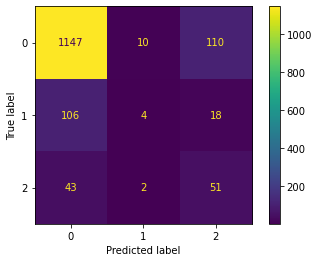

In [77]:
# get predictions and labels
preds_and_labels = rf_preds_w.select(['prediction','label']) \
                                  .withColumn('label', F.col('label').cast(FloatType())) \
                                  .orderBy('prediction') \
                                  .toPandas()

# get confusion matrix
cm = confusion_matrix(preds_and_labels["label"], preds_and_labels["prediction"], labels=[0, 1, 2])
# get confusion matrix figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
# plot figure
disp.plot()

## 6.2 Variable importance

In [254]:
import matplotlib.pyplot as plt 
# inspect feature importance
feature_importance = RF_pipeline_w.stages[-1].featureImportances.toArray()
#feature_importance


In [167]:
# transform training set
train_final = RF_pipeline_w.transform(train).select(["label", "features"])
train_final.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(90,[0,1,2,3,4,8,...|
|  1.0|(90,[0,1,4,8,9,10...|
|  0.0|(90,[0,1,3,4,8,9,...|
|  0.0|(90,[1,4,8,10,11,...|
|  0.0|(90,[1,4,8,10,11,...|
+-----+--------------------+
only showing top 5 rows



In [209]:
# let's get a better overview by including the feature names:
# import required packages
import pandas as pd
import numpy as np

# get coefficients and intercept
feature_importance = RF_pipeline_w.stages[-1].featureImportances.toArray()

# get feature names and sort in correct order
names = [x["name"] for x in sorted(train_final.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]+
                                   train_final.schema["features"].metadata["ml_attr"]["attrs"]["binary"], 
                                   key = lambda x: x["idx"])]

In [227]:
# create 2D numpy array
var_imp = np.column_stack((np.array(names), feature_importance))

var_imp = pd.DataFrame(var_imp)
var_imp.columns=['Feature', 'Importance']
var_imp = spark.createDataFrame(var_imp)
var_imp = var_imp.withColumn("Importance", F.col("Importance").cast('double'))


# show highest values
var_imp.sort('Importance', ascending = False).show(5, truncate=False)

# show lowest values
#var_imp.sort('Importance', ascending = True).show(5, truncate=False)

+------------------------------+--------------------+
|Feature                       |Importance          |
+------------------------------+--------------------+
|num_features_nr_tweets_by_user|0.3315560604631174  |
|num_features_user_following   |0.19810661708468527 |
|num_features_user_age_days    |0.13721927020978572 |
|num_features_num_words        |0.031203895193690035|
|num_features_upper_case_words |0.026535627375610892|
+------------------------------+--------------------+
only showing top 5 rows



iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


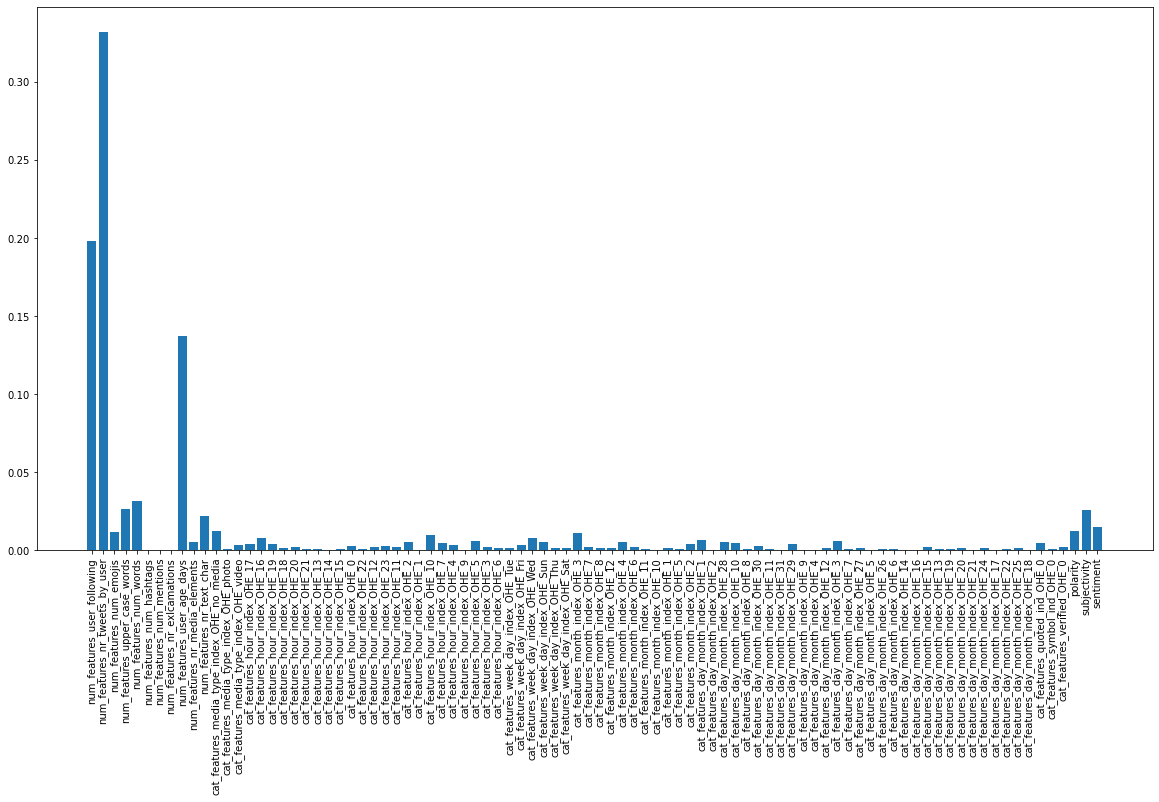

In [236]:
# plot
plt.figure(figsize=(20, 10))
plt.bar(x=range(len(feature_importance)), height=feature_importance)
plt.xticks(range(len(feature_importance)), np.array(names), rotation=90)
plt.show()

In [ ]:
# plot
plt.figure(figsize=(20, 10))
plt.bar(x=range(len(important_features)), height=important_features)
plt.xticks(range(len(important_features)), np.array(names), rotation=90)
plt.show()

In [291]:
# join these results with the results from the logistic regression to determine the importance
# of the features:
# join the 3 dataframes
interpretation = var_imp.join(coefs_df, on = "Feature", how="inner") \
                     .join(coefs_df_2, on = "Feature", how="inner")

# show most important variables
interpretation.sort('Importance', ascending = False).toPandas().head(20)

,Feature,Importance,Coefvalue_class_0,Coefvalue_class_1,Coefvalue_class_2,Coefvalue_class_2
0,num_features_nr_tweets_by_user,0.331556,0.000048,0.000014,-0.000062,-0.000062
1,num_features_user_following,0.198107,0.000235,-0.000141,-0.000095,-0.000095
2,num_features_user_age_days,0.137219,0.000158,0.000022,-0.000181,-0.000181
3,num_features_num_words,0.031204,-0.009470,0.025913,-0.016444,-0.016444
4,num_features_upper_case_words,0.026536,0.029983,-0.038070,0.008087,0.008087
5,subjectivity,0.025882,0.054561,0.303826,-0.358387,-0.358387
6,num_features_nr_text_char,0.021757,0.001128,-0.002963,0.001835,0.001835
7,sentiment,0.015102,0.400567,0.283823,-0.684390,-0.684390
8,polarity,0.012592,0.193951,-0.484896,0.290946,0.290946
9,cat_features_media_type_index_OHE_no_media,0.012470,-1.891019,-0.435611,2.326630,2.326630


+-----------------+-----+
|nr_tweets_by_user|count|
+-----------------+-----+
|            58877|    1|
|            46424|    1|
|               26|    7|
|            17971|    1|
|            92741|    1|
|           537860|    1|
|             4371|    1|
|             1840|    2|
|            84995|    1|
|            72882|    1|
|             1145|    1|
|             1642|    2|
|             4509|    1|
|            32895|    1|
|              720|    3|
|           124523|    1|
|             6508|    1|
|               19|    1|
|              847|    1|
|            29829|    1|
+-----------------+-----+
only showing top 20 rows



In [235]:
# visualize
#tree = RF_pipeline.stages[-1]
#display(tree) #visualize the decision tree model
#print(tree.toDebugString) #print the nodes of the decision tree model